In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

classes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']


def plot_mc_roc(Y_test_bin, Y_test_proba, n_classes, title='ROC Curve'):
    ax = plt.axes()
    leg = []
    for i in range(n_classes):
        y_score = Y_test_proba[:, i]
        fpr, tpr, _ = roc_curve(Y_test_bin[:, i], y_score)
        roc_auc = auc(fpr, tpr)
        leg.append(classes[i] + ' (auc = {:.4})'.format(roc_auc))
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)

    plt.xlim((0, .4))
    plt.ylim((.6, 1))
    plt.legend(leg)
    plt.title(title)


In [2]:
import pandas as pd

# read in all data
test = pd.read_csv('../data/test.txt', delimiter=';', names=['text', 'target'])
train = pd.read_csv('../data/train.txt', delimiter=';',
                    names=['text', 'target'])
val = pd.read_csv('../data/val.txt', delimiter=';', names=['text', 'target'])
trainval = pd.concat([train,val])
testval = pd.concat([test,val])

In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

# create vectorier for BoW
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english', ngram_range=(1, 1))
BoW = vectorizer.fit_transform(trainval.text)
print('Number of Features in BoW: ', len(vectorizer.get_feature_names_out()))

enc = LabelEncoder().fit(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

# transform all the data
X_trainval = vectorizer.transform(trainval.text).toarray()
Y_trainval = enc.transform(trainval.target)
X_train = vectorizer.transform(train.text).toarray()
Y_train = enc.transform(train.target)
X_val = vectorizer.transform(val.text).toarray()
Y_val = enc.transform(val.target)
X_test = vectorizer.transform(test.text).toarray()
Y_test = enc.transform(test.target)

Number of Features in BoW:  3398


### Coarse Hyperparameter Search
Performing a course randomized search cross-validation to get an estimate of where the best model resides in the design space. Further tuning and optimization will be performed based on the results of the randomized cross-validation.

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

clf = XGBClassifier(random_state=0, eval_metric='mlogloss', use_label_encoder=False)

params = {'n_estimators':[10, 50, 100, 250, 500],
          'max_depth':[1, 5, 10, 25, 50],
          'reg_alpha':[0, .1, 1, 10, 100],
          'learning_rate':[.01, .1, .25, .5, 1]
          }

#grid_cv = GridSearchCV(clf,param_grid=params, scoring='f1_macro', verbose=3, n_jobs=1, cv=5)
rand_cv = RandomizedSearchCV(clf, param_distributions=params, n_iter=25, n_jobs=-1, verbose=1, scoring='f1_macro', cv=2, random_state=0)
rand_cv.fit(X_trainval, Y_trainval)


Fitting 2 folds for each of 25 candidates, totalling 50 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=n...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

print('Best Parameters: ', rand_cv.best_params_)
print('Best Score: ', rand_cv.best_score_)
best_model = rand_cv.best_estimator_

res = rand_cv.cv_results_
res.pop('params',None)
res.pop('split0_test_score',None)
res.pop('split1_test_score',None)
pd.DataFrame(res).sort_values('rank_test_score')

Best Parameters:  {'reg_alpha': 0, 'n_estimators': 50, 'max_depth': 25, 'learning_rate': 0.5}
Best Score:  0.8562777731856552


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,mean_test_score,std_test_score,rank_test_score
7,1956.732203,0.278256,0.726059,0.016955,0,50,25,0.5,0.856278,0.000464,1
8,3795.248049,2.996988,1.262126,0.117186,1,500,5,1,0.855536,0.000719,2
0,3753.074003,0.391952,1.221235,0.020445,0.1,50,50,0.25,0.854635,0.000892,3
17,2018.713057,2.025694,1.782696,0.588007,0.1,100,10,0.5,0.854439,0.000261,4
6,7862.493680,12.476177,2.832842,0.195687,0,100,50,0.1,0.854203,0.000959,5
24,3367.773519,1.702448,0.811330,0.045378,0,500,5,1,0.851005,0.000704,6
16,4729.419862,10.702887,1.418708,0.002494,0.1,100,25,0.1,0.849252,0.000598,7
23,3747.292422,21.402284,1.013291,0.141621,10,100,50,0.25,0.847652,0.000719,8
22,517.921786,3.224764,0.452790,0.030917,0.1,250,1,1,0.845676,0.001051,9
19,12175.403957,33.137093,2.595061,0.144613,0,500,50,0.5,0.843956,0.000262,10


Coarse Estimation Best Model Accuracy:  0.8965
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       275
           1       0.86      0.88      0.87       224
           2       0.91      0.92      0.92       695
           3       0.77      0.76      0.76       159
           4       0.95      0.92      0.94       581
           5       0.68      0.73      0.70        66

    accuracy                           0.90      2000
   macro avg       0.85      0.86      0.85      2000
weighted avg       0.90      0.90      0.90      2000



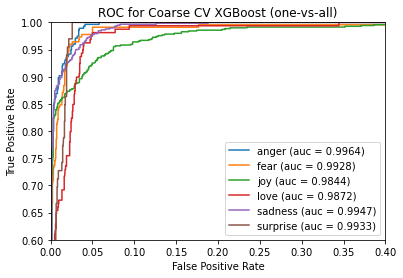

In [50]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Y_test_pred = best_model.predict(X_test)
print('Coarse Estimation Best Model Accuracy: ', accuracy_score(Y_test, Y_test_pred))
print(classification_report(Y_test, Y_test_pred))


Y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4, 5])
Y_test_proba = best_model.predict_proba(X_test)
plot_mc_roc(Y_test_bin, Y_test_proba, n_classes=6,
            title='ROC for Coarse CV XGBoost (one-vs-all)')


### Analysis of Coarse Hyperparameter Estimation
